<a href="https://colab.research.google.com/github/micheleavella/game_theory_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of Dynamic Game Theory to efficient parcels collection
All the infos [here](https://github.com/micheleavella/game_theory_project).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import os
from IPython.display import clear_output
from numba import njit

## Multiple drones with multiple boxes
drones $i$, bokes $k$.
$$
u_i(\mathbb X, \mathbb B)=\left\langle \frac{100}{1+|\vec x_i - \vec b|^2} \right\rangle_{\vec b \in\mathbb B} - \left\langle \frac{\gamma \cdot 50}{1+|\vec x_i - \vec y|^2}\right \rangle_{\vec y \in \mathbb X}
$$
Where $d^2(,)$ is the square distance. $\gamma$ is a real positive parameter that controls how much drones want to stay distant from each other.

In [2]:
@njit
def u_fast(x,X,B,DIM,coop):
    for i in range(len(X)): 
        if np.all(x==X[i]): return -1000         #crash
    if np.any(x<0) or np.any(x>=DIM): return -1000     #ouside map
    D = 0 
    for b in range(len(B)):
        D += 100/(1+np.sum((x-B[b])**2))
    D = D/len(B)
    R = 0 
    for b in range(len(X)):
        R += 50/(1+np.sum((x-X[b])**2))
    R = R/len(X)*coop
    return D-R

@njit
def NE_matrix(D,B,pl,temp,mov,u_fast,DIM,coop):
    S = np.zeros((4**len(D),len(temp[0])))
    best = np.zeros(4**len(D))

    cont_S = 0
    cont_best = 0
    for s in range(len(temp)):
        X = np.copy(D)
        P = X[np.delete(np.arange(len(X)),pl)]   
        for j in range(len(P)): P[j] += mov[temp[s,j]]
        u = np.zeros(len(mov))
        for j in range(len(mov)):
            p = np.copy(X[pl]) 
            p += mov[j]
            u[j] = u_fast(p,X,B,DIM,coop)
        for i in np.argwhere(u == np.max(u)).flatten() : 
            S[cont_S] = temp[s]
            best[cont_best] = i
            cont_S+=1; cont_best+=1
        
    return best[:cont_best],S[:cont_S]

class GAME:
    def __init__(self, DIM, n_d, n_b, coop):
        A = [0,1,2,3]
        self.coop = coop
        self.DIM = DIM
        self.n_d = n_d
        self.n_b = n_b
        self.drones = [Drone(self.DIM) for i in range (n_d)]
        self.boxes = [Box(self.DIM) for i in range (n_b)]
        self.mov = np.array([np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])])
        self.temp = np.array(list(product(A, repeat = n_d-1)))
        self.hist = []
        self.hist_b = np.copy(self.boxes)
        for i in range(n_d): self.hist.append([np.copy(self.drones[i].x)])

    
    def NE_fast(self,D,B,p,temp,mov):
        best,S = NE_matrix(D,B,p,temp,mov,u_fast,self.DIM,self.coop)
        pl = np.insert(S,p,best,axis =1)
        t=set([tuple(x) for x in pl])
        return t

    def step_fast(self):
        mov = self.mov
        temp = self.temp
        D = np.array([d.x for d in self.drones])
        B = np.array([d.x for d in self.boxes])

        out = []
        for p in range(len(D)):
            out.append(self.NE_fast(D,B,p,temp,mov))
        out = set.intersection(*out)
        out = list(out)

        pay = []
        for s in out:
          X = np.copy(D) #pos prima di muovere
          for x,i in zip(X,s):
            x += mov[int(i)]
          #X droni mossi
          app = []
          for i in range(len(X)):
            p = np.copy(X[i])
            P = np.copy(X)
            P = X[np.delete(np.arange(len(X)),i)]
            app.append(u_fast(p,P,B,self.DIM,self.coop))
          pay.append(app)
        pay = np.array(pay)
        mm = np.argmax(np.mean(pay,axis=1))
        ris = out[mm]          #now I'm chosing a random NE but I should chose the best one (NON SON SICURO)

        for d in range(len(self.drones)):   
            self.drones[d].moves(int(ris[d]))
            self.hist[d].append(np.copy(self.drones[d].x))
        
    def hit_box(self):
        for d in self.drones:
            for j in range(len(self.boxes)):
                if np.all(d.x == self.boxes[j].x): 
                    self.boxes.pop(j)
                    clear_output(wait=True)
                    print('Boxes left: ',len(self.boxes))
                    break

    #play the game
    def play(self):
        CONT = 0
        n_b = len(self.boxes)
        while self.boxes:
            CONT += 1
            self.step_fast() #make a step
            self.hit_box()
        clear_output(wait=True)
        print('DONE :)')
        return(CONT)
            


class Drone:
    def __init__(self, DIM):
        self.x = np.random.randint(0,DIM,2)
        #self.x = np.array([10,10])
        self.mov = [np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    def moves(self,i):
        self.x += self.mov[i]

class Box:
    def __init__(self, DIM):
        self.x = np.random.randint(0,DIM,2)

In [13]:
np.random.seed(12345)
N_DRONES = 2
N_BOXES=10
L = 10
g = GAME(L,N_DRONES,N_BOXES,coop=1)
g.boxes
_ = g.play()

DONE :)


In [15]:
ris = []
Hist = []
for i in range(2):
    #seed 123 buono con 5,6 droni
    np.random.seed(12376)
    g = GAME(70,6,70,i)
    ris.append(g.play())
    Hist.append(g.hist)

print(ris)

DONE :)
[160, 124]


(-1.0, 71.0)

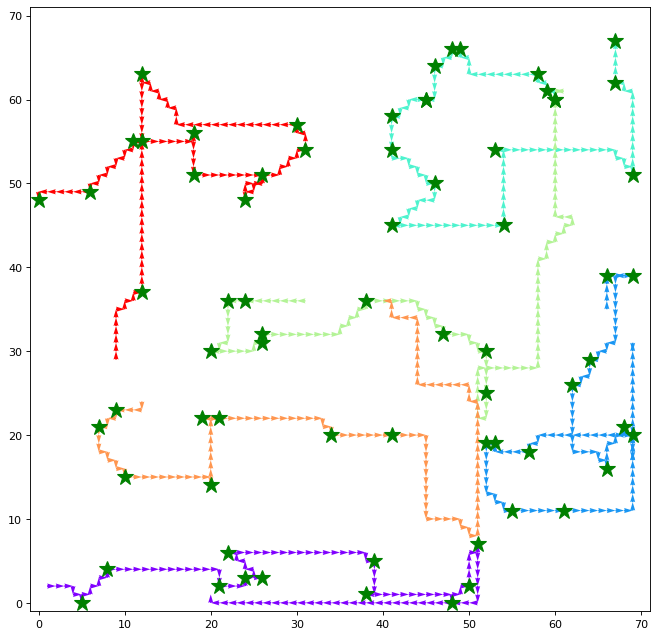

In [16]:
from matplotlib.pyplot import cm
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 80


DIM = g.DIM
fig = plt.figure(figsize = (10,10))
color = cm.rainbow(np.linspace(0, 1, len(g.hist)))

for H,C in zip(g.hist,color):
    d1 = np.array(H)
    x = d1[:,0]
    y = d1[:,1]
    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,width=0.004 , color = C)


for b in g.hist_b: 
    plt.plot(b.x[0],b.x[1],'*',color='green',markersize=15)


plt.xlim([-1, DIM+1])
plt.ylim([-1, DIM+1])


(-1.0, 71.0)

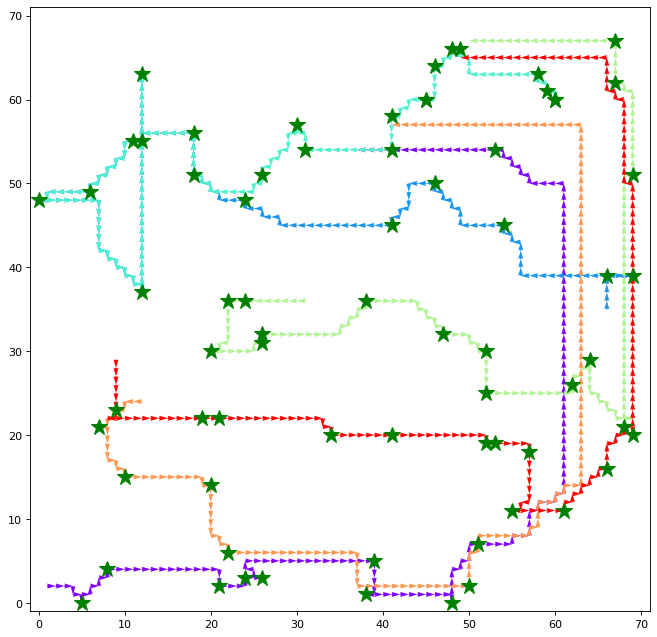

In [17]:
from matplotlib.pyplot import cm
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 80


DIM = g.DIM
fig = plt.figure(figsize = (10,10))
color = cm.rainbow(np.linspace(0, 1, len(g.hist)))

for H,C in zip(Hist[0],color):
    d1 = np.array(H)
    x = d1[:,0]
    y = d1[:,1]
    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1,width=0.004 , color = C)


for b in g.hist_b: 
    plt.plot(b.x[0],b.x[1],'*',color='green',markersize=15)


plt.xlim([-1, DIM+1])
plt.ylim([-1, DIM+1])
